<img align="right" src="https://rega.kuleuven.be/cev/viralmetagenomics/pictures/lovm/image_preview" height="10%" width="10%" />

# JM-lab bioinformatics pipeline
This jupyter notebook gives an overview of the commands needed for the primary analysis of raw NGS data, flavoured with explanations and neat tips and tricks. This is intended as a learning tool for new PhD-students, master students, interns, etc. Basic command-line knowledge is required to be able to complete this tutorial, a Linux introduction course like [this one](https://ryanstutorials.net/linuxtutorial/) should suffice.

This tutorial can be followed by running the commands directly from the terminal or within this jupyter notebook. To run a jupyter notebook on the teaching server, copy it to the `~/data/jupyternotebooks/` folder and open an internet browser to navigate to [bmw.gbiomed.kuleuven.be](https://bmw.gbiomed.kuleuven.be/), log in with your KU Leuven credentials which should finally allow you to run the notebook. You can find more information on how to transfer files to a remote server [below](#1.2-Installing-an-SFTP-client).

#### Requirements:

* Internet connection
* Basic Linux command-line knowledge
* Local copy of the [Github repository](https://github.com/Matthijnssenslab) with this jupyter notebook, solutions notebook, extra solution files, etc.
* NetoVIR FASTQ-files, custom DIAMOND and Krona databases from the J-drive
* Bioinformatics mood

#### Overview:

* [Part 1: Preparation](#Part-1:-Preparation)
* [Part 2: Pipeline](#Part-2:-Virome-pipeline)
    * [Basic NGS commands](#Basic-commands-when-working-with-NGS-data)
    * [Trimming and QC](#2.1-Trimming-and-QC)
    * [Removing contamination](#2.2-Removing-contamination)
    * [Assembly](#2.3-Assembly)
    * [Taxonomical annotation](#2.4-Taxonomical-annotation)
    * [Krona](#2.5-Krona)
---
## **Part 1: Preparation**
### 1.1 Logging into the teaching server
To be able to perform analysis on a Linux machine or a server, a connection needs to be made through the shell of the operating system. Through this shell we can use the command-line interface to execute tasks.

For this tutorial we can work on the teaching server of gbiomed (bmw.gbiomed.kuleuven.be). Everyone with a u- or r-number from KU Leuven can connect to this remote server by using `ssh` ([more info](https://searchsecurity.techtarget.com/definition/Secure-Shell)) with your KU Leuven credentials.

MacOS and Linux users can already proceed to the next step as these operating systems already have a terminal and `ssh` natively installed. 

Windows users on the other hand, will have to install an SSH client ([PuTTY](https://www.chiark.greenend.org.uk/~sgtatham/putty/latest.html) or [Bitvise](https://www.bitvise.com/ssh-client-download)) or a Linux subsytem for Windows (the latter is preferred because it is already a part of Windows and subsequently the next steps will be the same as for Linux and Mac users). Instructions on how to install Ubuntu on Windows can be found [here](https://ubuntu.com/tutorials/ubuntu-on-windows#1-overview), be aware that this requires at least a x86 PC running Windows 10 (Fall Creators update Oct 2017).

**Perform following actions in a terminal (command-line interface):**

<span style="color:red">Replace uXXXXXXX with your u- or r-number. </span>

In [ ]:
ssh uXXXXXXX@bmw.gbiomed.kuleuven.be

Next, you should give your password connected to your KU Leuven account and you're in!

<b><span style="color:red"> Important:</span> You will log in to the `home` directory, but always avoid working in here as this has limited storage and will cause trouble when it's full!</b> Therefore, on the teaching server, work in the `data` directory, which is a symbolic link to `/mnt/storage/uXXXXXXX`. Here, you will have enough space to store raw data, results and databases.

### 1.2 Installing an SFTP client

In order to transfer files from your local computer to a remote server you need an SFTP (SSH or Secure File Transfer Protocol) client, a commonly used SFTP client is [FileZilla](https://filezilla-project.org/). You can download and install it through the FileZilla project website.

*Note: Bitvise is an SSH and SFTP client in one, so if you're using Bitvise there is no need to install FileZilla.*

Once you installed and opened FileZilla, it should look like this:

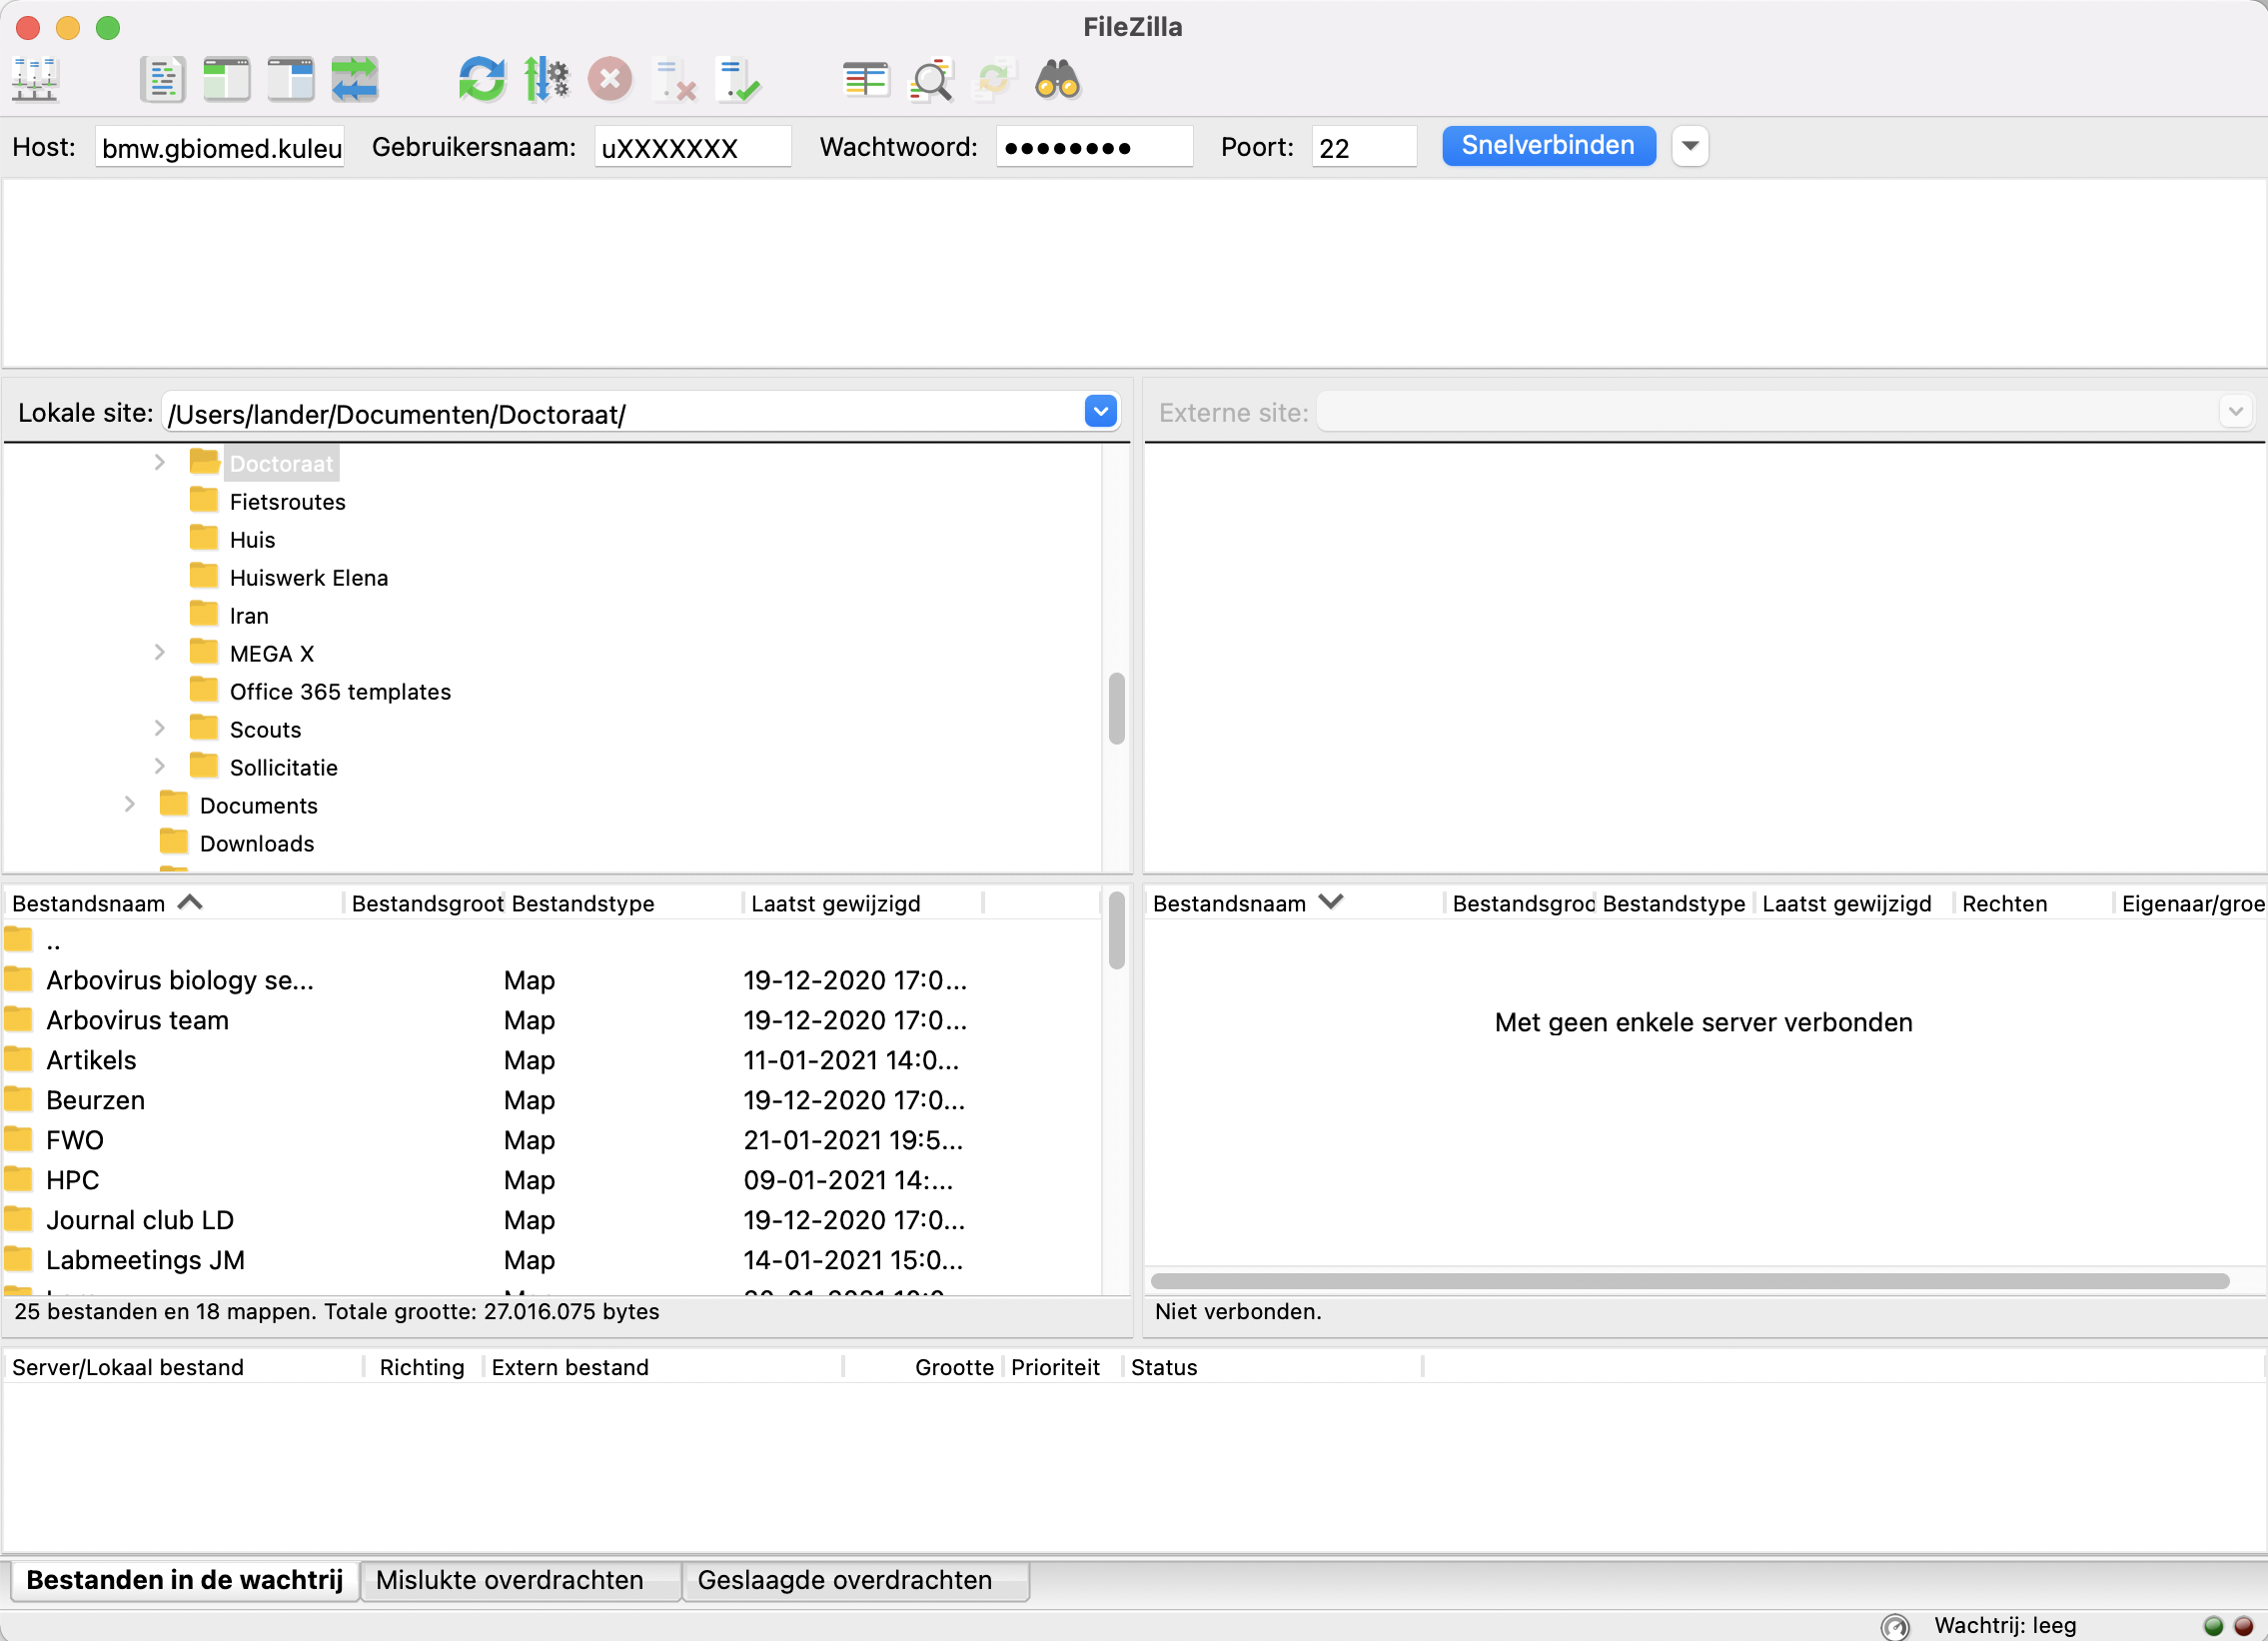
<br>
<center><img src="images/Filezilla_start.png" height="60%" width="60%" /></center>

On top of the program you can fill out the host (bmw.gbiomed.kuleuven.be), your u/r-number and password connected to KU Leuven and set the port to 22 (see image above). 

Once you click connect you should be able to transfer files from your computer to the remote server simply by dragging them one or the other way.

<center><img src="images/Filezilla_transfer.png" height="60%" width="60%" style="left" /></center>

<span style="color:red"> Important:</span> FileZilla will connect to your `home` directory by default, but do not copy files here! Instead, copy them to the `data` directory.

#### 1.2.1 Transfer files
Make a new directory in your data folder and transfer all provided files (FASTQ, database, primer file, etc.) to this directory with FileZilla.

In [ ]:
mkdir ~/data/meta_tutorial

### 1.3 Installing all necessary software on the remote server
#### 1.3.1 Miniconda
(Mini)conda is a package manager from which you can install a lot of (bioinformatics) software. More info on conda can be found [here](https://docs.conda.io/projects/conda/en/latest/).

**Perform following steps to install all software we will need along the pipeline:**
1. Create in your datafolder a new `software` directory and move into that directory:

In [ ]:
cd ~/data
mkdir software
cd software
pwd

2. Download the Miniconda installer with `wget`. Next, run the installation script (`-b` makes the installation run silent and `-p` provides the path where to install Miniconda). When Miniconda is installed, activate conda by sourcing the initialization script, this simply sets a couple of shell environment variables, and `conda` command as a shell function. More information in the [installer guidelines](https://docs.conda.io/projects/conda/en/latest/user-guide/install/index.html).

In [ ]:
wget https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
bash Miniconda3-latest-Linux-x86_64.sh -b -p $HOME/data/software/miniconda
source $HOME/data/software/miniconda/bin/activate
conda init
source ~/.bashrc

*Notice that* `$HOME` *and* `~/` *both point to your `home` directory.*

3. When installing new software with conda, the best practice is to create a new conda environment for each project you are working on, for example:

In this tutorial we will run the virome pipeline, so we will create a conda environment with all software we need to run the pipeline installed in this environment. Then we need to activate this environment to make the software available for use.


In [ ]:
conda create -y --name virome_pipeline python
conda activate virome_pipeline
conda install -y -c bioconda -c anaconda krona samtools bwa-mem2 bowtie2 trimmomatic bedtools fastqc pigz seqtk

##### Downloading taxonomy database for Krona
Krona is installed but we still need to run `ktUpdateTaxonomy.sh` to download the taxonomy database, see message below:

```console
Krona installed.  You still need to manually update the taxonomy databases before Krona can generate taxonomic reports. The update script is ktUpdateTaxonomy.sh. 
The default location for storing taxonomic databases is /home/luna.kuleuven.be/u0140985/data/software/miniconda/envs/virome_pipeline/opt/krona/taxonomy

If you would like the taxonomic data stored elsewhere, simply replace
this directory with a symlink.  For example:
```
```bash
rm -rf /home/luna.kuleuven.be/u0140985/data/software/miniconda/envs/virome_pipeline/opt/krona/taxonomy
mkdir /path/on/big/disk/taxonomy
ln -s /path/on/big/disk/taxonomy /home/luna.kuleuven.be/u0140985/data/software/miniconda/envs/virome_pipeline/opt/krona/taxonomy
ktUpdateTaxonomy.sh
```

In [ ]:
ktUpdateTaxonomy.sh

#### 1.3.2 From another source

The bioconda installation will most of the time lag a few versions behind the most current release. If you really want the most recent, then you'll need to manually install the software and its dependencies.

Next to Anaconda/Miniconda their are a lot of other possibilities to install software (`pip`, compiling from source, unpacking binaries, installing from github repository, etc.)

As the latest version of [Diamond](https://github.com/bbuchfink/diamond) (a sequence aligner for protein and translated DNA searches) is not available through `conda`, we can install it from github by following the [installation instructions](https://github.com/bbuchfink/diamond/wiki).

In [ ]:
cd ~/data/software/
mkdir diamond
cd diamond
wget http://github.com/bbuchfink/diamond/releases/download/v2.0.6/diamond-linux64.tar.gz
tar -xzf diamond-linux64.tar.gz

Now we still need to put the diamond executable in our `PATH` variable so we can call the `diamond` command from everywhere in the command line. This can be done by making a `bin` subdirectory in `~/data/software/`, followed by creating a symlink from the `diamond` executable to `~/data/software/bin/` and finally export this directory to our `$PATH` by adding it to your `.profile` file.

In [ ]:
cd ~/data/software
mkdir bin
cd bin/
ln -s ~/data/software/diamond/diamond .

Next, open the `.profile` file with `nano` (a text editor) and add following line to the bottom of the file:
```bash
PATH="~/data/software/bin:$PATH"
```
More documentation on where and how to set the `PATH` variable in these two topics: 
* https://superuser.com/questions/183870/difference-between-bashrc-and-bash-profile/183980#183980 
* https://unix.stackexchange.com/questions/26047/how-to-correctly-add-a-path-to-path


When you `source` your `.profile` file, you should now be able to call `diamond`.

In [ ]:
source ~/.profile

Let's check out the version of Diamond you have installed!

In [ ]:
diamond version

#### 1.3-1 Exercise
Try to install the latest version of [SPAdes](https://github.com/ablab/spades) by yourself. If you have troubles with this exercise, the steps are listed in the solutions notebook.

---
## **Part 2: Virome pipeline**

Before we start, some commandments to live by:
1. **Always make sure you're working in the right directory** (`pwd`) and that you **activated the `conda` environment**
2. Try the `-h`, `-help` or `--help` documentation for more information about the pogram you're using.
3. **<kbd>Ctrl</kbd> + <kbd>C</kbd>** kills tasks, useful when they get stuck 
4. Undoubtedly **errors will occur**, read them carefully and **try to understand what they want to tell you**. 
5. **Document what you're coding**: Use `#` in a shell script, code block, etc., this will allow you to leave comments in your code, as all lines with a `#` in front will not be interpreted.
6. **Google is your friend!** Websites like Stackoverflow, Superuser, Biostars, etc. most likely contain the answers to your questions (if you can phrase them properly)

### Basic commands when working with NGS data
Commands to do some basic manipulations on sequence data are given below. These always come in handy when working with fasta/fastq files.
1. Count how many reads are in a fastq.gz:

In [ ]:
zcat <fastq.gz> | echo $((`wc -l`/4)) #when you have an uncompressed fastq, replace zcat with cat

2. Count how many sequences are in a fasta:

In [ ]:
grep -c ">" <fasta> #grep -c will count occurrence of >, which is the start of each fasta header

3. Convert fastq to fasta:

In [ ]:
seqtk seq -a <fastq> > <fasta> #seqtk has to be installed

4. Subset of specific fasta sequences from multifasta:

In [ ]:
seqtk subseq <multifasta> <list-header-id> #seqtk has to be installed

5. Get the sequence length and nucleotide distribution in a fasta:

In [ ]:
seqtk comp <fasta> #seqtk has to be installed

---
### 2.1 Trimming and QC
**Raw reads are imperfect** due to presence of primer and adapter sequences from WTA2, Nextera library prep,... and because NGS inherently produces some errors during base calling. The quality of such a base call gets encoded in a FASTQ file as a [PHRED-score](https://en.wikipedia.org/wiki/Phred_quality_score#:~:text=The%20FASTQ%20format%20encodes%20phred,efficacy%20of%20different%20sequencing%20methods.). This also means that the raw reads have to be filtered and trimmed for these imperfections. We can do this by using software (eg. Trimmomatic, cutadapt, etc.) that will trim the reads based on base call quality and the presence of adapter sequences provided by the user. However, also after trimming your reads, it is best to check the quality of you samples.

#### 2.1.1 Trimmomatic
We start by trimming the reads in our sample with Trimmomatic, a flexible read trimming tool for Illumina NGS data.

The current Trimmomatic trimming steps are:

- **ILLUMINACLIP**:<i>\<fastaWithAdaptersEtc>:\<seed mismatches>:\<palindrome clip>:\<simple clip threshold> </i><br /> Cut adapter and other illumina-specific sequences from the read. You can provide a file with all sequences to cut (for this tutorial we use *primer_WTA2_Nextera.fa*).
- **SLIDINGWINDOW**:<i>\<windowSize>:\<requiredQuality> </i><br />Perform a sliding window trimming, cutting once the average quality within the window falls below a threshold. By considering multiple bases, a single poor quality base will not cause the removal of high quality data later in the read. 
- **LEADING**:<i>\<quality> </i> <br />Cut bases off the start of a read, if below a threshold quality
- **TRAILING**:<i>\<quality> </i> <br />Cut bases off the end of a read, if below a threshold quality
- **CROP**:<i>\<length> </i> <br />Cut the read to a specified length *(not used in our pipeline)*
- **HEADCROP**:<i>\<length> </i> <br />Cut the specified number of bases from the start of the read
- **MINLEN**:<i>\<length> </i> <br />Drop the read if it is below a specified length

It works with FASTQ, either uncompressed or gzipp'ed FASTQ. Use of gzip format is determined based on the .gz extension.

For single-ended data, one input and one output file are specified, plus the processing steps. For paired-end data, two input files are specified, and 4 output files, 2 for the 'paired' output where both reads survived the processing, and 2 for corresponding 'unpaired' output where a read survived, but the partner read did not.

In [ ]:
#move to the directory where you stored the tutorial files
cd ~/data/meta_tutorial
pwd #make sure you're in the right directory

1. Make new folders where you will store the data for each individual metatoy.

In [ ]:
mkdir metatoy
cd metatoy
mkdir READ
mv ../metatoy.R* ./READ
cd ./READ
mkdir TRIMMED

2. After unzipping the FASTQ files, start Trimmomatic:

In [ ]:
pwd #your working directory should be ~/data/meta_tutorial/metatoy/READ/ if you used the same names as in this notebook

pigz -d -p 20 -c metatoy.R1.fastq.gz > metatoy.R1.fastq
pigz -d -p 20 -c metatoy.R2.fastq.gz > metatoy.R2.fastq

#PE stands for Paired-end, for single-end reads use SE
trimmomatic PE -threads 20 metatoy.R1.fastq metatoy.R2.fastq \ #the backslash (\) allows us to let the command continue over multiple lines
                TRIMMED/metatoy.R1.trimmed.fastq TRIMMED/metatoy.R1.unpaired.fastq TRIMMED/metatoy.R2.trimmed.fastq \
                TRIMMED/metatoy.R2.unpaired.fastq \
                ILLUMINACLIP:~/data/meta_tutorial/primer_WTA2_Nextera.fa:2:30:10:1:true \
                HEADCROP:19 LEADING:15 TRAILING:15 SLIDINGWINDOW:4:20 MINLEN:50

*Try to understand what all specified options do in the Trimmomatic command. <br>Hint: Remember the 6th commandment.*

<details>
    <summary>Solutions for the Trimmomatic options</summary>
    More info in the <a href="http://www.usadellab.org/cms/uploads/supplementary/Trimmomatic/TrimmomaticManual_V0.32.pdf">manual</a>
    <br>
    <hl><b> ILLUMINACLIP: </b></hl>
        <li><code>~/data/meta_tutorial/primer_WTA2_Nextera.fa</code>: provides the path to the fasta file with adapter and primer sequences </li>
        <li><code>2</code>: represents the number of max mismatches allowed to still perform a full match with an adapter sequence</li>
        <li><code>30</code>: specifies how accurate the match between the two 'adapter ligated' reads must be for PE palindrome read alignment</li>
        <li><code>10</code>: specifies how accurate the match between any adapter sequence must be against a read.</li>
        <li><code>1</code>: a minimal adapter length of 1 allows for shorter adapter fragments to be removed </li>
        <li><code>true</code>: retain the reverse read</li>
    <br>
    <hl><b>HEADCROP:</b></hl>
    <li><code>19</code>: remove the first 19 bases of the read</li>
    <br>
    <hl><b>LEADING:</b></hl>
    <li><code>15</code>: bases at the beginning of the read with a PHRED-score below 15 will be removed</li>
    <br>
    <hl><b>TRAILING:</b></hl>
    <li><code>15</code>: bases at the end of the read with a PHRED-score below 15 will be removed</li>
    <br>
    <hl><b>SLIDINGWINDOW:</b></hl>
    <li><code>4</code>: determines the window size at 4bp to slide over the read</li>
    <li><code>20</code>: once the average quality in the window falls below 20, trimmomatic will cut the read</li>
    <br>
    <hl><b>MINLEN:</b></hl>
    <li><code>50</code>: drop reads shorter than 50bp</li>
</details>

3. Concatenate the unpaired reads together and in order to save storage space, remove all intermediary files and gzip the trimmed fastq files:

In [ ]:
cat TRIMMED/metatoy.R1.unpaired.fastq TRIMMED/metatoy.R2.unpaired.fastq > TRIMMED/metatoy.unpaired.fastq
rm TRIMMED/metatoy.R1.unpaired.fastq
rm TRIMMED/metatoy.R2.unpaired.fastq
cd TRIMMED

pigz -p 20 -c -9 metatoy.R1.trimmed.fastq > metatoy.R1.trimmed.fastq.gz
pigz -p 20 -c -9 metatoy.R2.trimmed.fastq > metatoy.R2.trimmed.fastq.gz
pigz -p 20 -c -9 metatoy.unpaired.fastq > metatoy.unpaired.trimmed.fastq.gz

rm metatoy.R1.trimmed.fastq
rm metatoy.R2.trimmed.fastq
rm metatoy.unpaired.fastq

#### 2.1.2 FastQC
Most sequencers will generate a QC report as part of their analysis pipeline, but this is usually only focused on identifying problems which were generated by the sequencer itself. FastQC aims to provide a QC report which can spot problems which originate either in the sequencer or in the starting library material.

FastQC aims to provide a simple way to do some quality control checks on raw sequence data coming from high throughput sequencing pipelines. It is very useful software to visually inspect the quality of samples and runs for most of the current sequencing platforms (Illumina, IonTorrent, Nanopore, etc.).

In [ ]:
cd ~/data/meta_tutorial/metatoy
mkdir fastqc
fastqc -o fastqc/ -t 6 READ/TRIMMED/*.fastq.gz #the wildcard '*' is used to run `fastqc` on all FASTQ files within the 'TRIMMED' folder

Check the generated HTML-files and look if your sample passes QC. In the `fastqc` folder of the tutorial's repository, you can find the FastQC-files of the reads **before** and **after** trimming (the latter should be the same as your own). Have a look at them and pay attention to the differences.

---
### 2.2 Removing contamination
When working in the lab it is likely that you introduce contamination to your samples, for example because the reagents are contaminated. That's why we also sequence some negative controls. By *de novo* assembling your negative controls first, you can create a **contaminome**. Subsequently, you can remove all reads in your samples that map to this contaminome.

#### 2.2.1 Mapping
Mapping is a **specific case of alignment** for aligning short sequences (reads) to a reference. This is performed by a short sequence aligner/mapper (eg. Bowtie, BWA, etc.). In this case, we align sequencing reads to the assembled contaminome sequences. The output of the mapping process is stored in **SAM-files** (Sequence Alignment Map) or their compressed equivalent **BAM** (Binary Alignment Map).

In the image below a visual representation is given on the mapping of reads to a reference sequence:
<br>
<center><img src="https://training.galaxyproject.org/training-material/topics/sequence-analysis/images/mapping/mapping.png" width="50%" heiht="50%" style="border: 1px solid black"/></center>
<center><b>Overview of read mapping to a reference sequence</b></center>
<br>

We will use `bowtie2` to map the reads in our sample to the contaminome. To calculate the statistics of the mapping and remove the mapped reads from our sample, we can use `samtools` and `bedtools`. <br />
In this tutorial, the contaminome is already assembled and indexed with `bowtie2`. You can find the files in the contaminome folder.

##### Bowtie
<a href="http://bowtie-bio.sourceforge.net/bowtie2/manual.shtml#introduction">Bowtie2</a> is an ultrafast and memory-efficient tool for aligning sequencing reads to long reference sequences.

Options:
* `-x` should point to the indexed reference sequence
* `--very-sensitive` aligns the reads on a sensitive setting at the cost of speed
* `-p` causes Bowtie2 to launch a specified number of parallel search threads
* `-S` specifies the output SAM file
* `-1` and `-2` should provide the input read files

In [ ]:
cd ~/data/meta_tutorial/metatoy/READ/TRIMMED
bowtie2 --very-sensitive -p 20 -x ~/data/meta_tutorial/contaminome/contaminome -1 metatoy.R1.trimmed.fastq.gz -2 metatoy.R2.trimmed.fastq.gz -S mapunmap_pair.sam

#### 2.2.2 Removing mapped reads
##### Samtools
<a href="http://www.htslib.org/">Samtools</a> is a set of utilities that manipulate alignments in the SAM/BAM format. It imports from and exports to the SAM format, does sorting, merging and indexing, and allows to retrieve reads in any regions swiftly.

An important function of `samtools` is the ability to keep or remove certain reads by specifying **SAM flags**. Reads are assigned a certain SAM flag, this number represents a certain combination of features of the alignment. Actually, the flag field consists of 10 bits, of which every bit is related to the abscence (0) or presence (1) of a feature. So while the features are stored in bitwise fashion, to report this number, the FLAG field converts these bits to a readable number, the number these bits represent. Unfortunately, this is number is still very user-unfriendly to read. Luckily, there are tools to convert this number into a feature list, like this one: https://broadinstitute.github.io/picard/explain-flags.html
<br>

**Different features of the reads:**

<table align="left">
<thead>
    <tr>
        <th align="left">Feature</th>
        <th align="left">SAM Flag</th>
    </tr>
</thead>
<tbody>
    <tr>
        <td align="left">read paired</td>
        <td align="right">1</td>
    </tr>
    <tr>
        <td align="left">all mate reads are mapped</td>
        <td align="right">2</td>
    </tr>
    <tr>
        <td align="left">read unmapped</td>
        <td align="right">4</td>
    </tr>
    <tr>
        <td align="left">mate unmapped</td>
        <td align="right">8</td>
    </tr>
    <tr>
        <td align="left">read reverse strand</td>
        <td align="right">16</td>
    </tr>
    <tr>
        <td align="left">mate reverse strand</td>
        <td align="right">32</td>
    </tr>
    <tr>
        <td align="left">first read of pair</td>
        <td align="right">64</td>
    </tr>
    <tr>
        <td align="left">second read of pair</td>
        <td align="right">128</td>
    </tr>
    <tr>
        <td align="left">secondary alignment</td>
        <td align="right">256</td>
    </tr>
    <tr>
        <td align="left">read fails quality checks</td>
        <td align="right">512</td>
    </tr>
    <tr>
        <td align="left">read is PCR or optical duplicate</td>
        <td align="right">1024</td>
    </tr>
    <tr>
        <td align="left">supplementary alignment</td>
        <td align="right">2048</td>
    </tr>
</tbody>
</table>

**Some examples:**

1. <span style="color:green"><b>Flag 16</b></span> indicates a <b>read on the reverse strand</b>. <br />
   **To exclude** all reads on the reverse strand we can use the `-F` option of `samtools`, `-f` on the other hand would **only include** reads on the reverse strand.

2. By combining flags, multiple combinations of features can be made, eg. <span style="color:green"><b>Flag 68</b></span> indicates that the <b>first read of the pair (<span style="color:green">flag 64</span>) is unmapped (<span style="color:green">flag 4</span>)</b>.

<br>

Try to figure out what `-f12` and `-F256` mean and think about why we would use these options?
<details>
    <summary>Solution</summary>
    <span style="color:green"><b>Flag 12</b></span> specifies all <b>unmapped reads and their mate</b>, we keep these by specifying the <code>-f</code> option. <br />
    <span style="color:green"><b>Flag 256</b></span> indicates a <b>secondary alignment</b>, this occurs when a given read could align reasonably well to more than one place. <code>-F</code> excludes all those reads. <br>
    We use specified options, because we like to exclude all reads that (ambigously) map to our contaminome.
</details>
<br>

In the end, we want to convert the resulting BAM file back to a FASTQ file, which can be handled by Bedtools' `bamToFastq`.

In [ ]:
samtools view -bS mapunmap_pair.sam | samtools view -b -f12 -F256 - | samtools sort -n - -o PEunmapped.sorted.bam
bamToFastq -i PEunmapped.sorted.bam -fq NCout.R1.fastq -fq2 NCout.R2.fastq
rm mapunmap_pair.sam
rm PEunmapped.sorted.bam
pigz -p 20 -c -9 NCout.R1.fastq > metatoy.NCout.R1.fastq.gz
pigz -p 20 -c -9 NCout.R2.fastq > metatoy.NCout.R2.fastq.gz

#### Exercise 2.2-1
For the unpaired reads we can do the same as above, try to fill in the template:

In [ ]:
bowtie2 ... -U ... #-U is the input for unpaired reads
samtools view ... | samtools view ... | samtools sort ...
bamToFastq ...
rm ...
rm ...
pigz ...

Remove all uncompressed FASTQ files:

In [ ]:
rm NCout.*.fastq

---
### 2.3 Assembly
Now that we have our contaminant filtered and trimmed reads, we have to reconstruct the genomes to which they belong. We can do this by **assembling** all reads into **contigs** (contiguous sequence). There are two types of assemblies: 
1. a __reference-guided assembly__: Your reads will get assembled based on a reference sequence you provide. This is used when you know what you are sequencing.
2. a __*de novo* assembly__: This method constructs genomes from a large number of (short- or long-) DNA fragments, with no a priori knowledge of the correct sequence or order of those fragments.

Overview of read assembly:

<center><img src="https://www.arraygen.com/images/de-novo.png" /></center>
<center><b><i>de novo</i> assembly</b></center>
<br>

We will use [(meta)SPAdes](https://cab.spbu.ru/software/spades/) to assemble our reads into contigs and eventually into scaffolds. 

The goal of whole-genome shotgun assembly is to represent each genomic sequence in one scaffold; however, this is not always possible. It depends on how completely the genome can be reconstructed, or assembled, from the available reads.

<figure>
    <center><img src="http://www.discoveryandinnovation.com/BIOL202/notes/images/end_reads3.jpg" width="50%" height="50%"/></center>
  <figcaption> <i>A scaffold is a portion of the genome sequence reconstructed from end-sequenced whole-genome shotgun clones. Scaffolds are composed of contigs and gaps (see image above). A contig is a contiguous length of genomic sequence in which the order of bases is known to a high confidence level. Gaps occur where reads from the two sequenced ends of at least one fragment overlap with other reads in two different contigs (as long as the arrangement is otherwise consistent with the contigs being adjacent). Since the lengths of the fragments are roughly known, the number of bases between contigs can be estimated.</i> </figcaption>
</figure>


In [ ]:
metaspades.py -1 ./READ/TRIMMED/metatoy.NCout.R1.fastq.gz -2 ./READ/TRIMMED/metatoy.NCout.R2.fastq.gz -s ./READ/TRIMMED/metatoy.NCout.unpaired.fastq.gz -t 20 -k 21,33,55,77 -o metatoy
mv metatoy ASSEMBLY
cd ASSEMBLY
mv scaffolds.fasta metatoy.scaffolds.fasta
#to add the sample names to your assemblies
sed -i "s/>.*/&_metatoy/" metatoy.scaffolds.fasta

---
### 2.4 Taxonomical annotation
Sequences or after assembly, contigs, can be identified/affiliated with several tools. Similarity can be measure by k-mer profile matching, similarity in alignments of fitness to a model. There are many programs and implementations for each, but the most known are Kraken (k-mer profile matching), Blast (alignment similarity) and HMMR (fitness to a hidden markov model).

**From Blast there are several options to query information:**

|BLAST|Query|Subject|
|:--|:--|:--|
|blastn|nucleotide|nucleotide|
|blastp|protein|protein|
|tblastn|protein|translated-nucleotide|
|blastx|translated-nucleotide|protein|
|tblastx|translated-nucleotide|translated-nucleotide|


In [ ]:
mkdir DIAMOND
cd DIAMOND

diamond blastx -d /staging/leuven/stg_00029/DB/nr/latest/nr.dmnd -q ../ASSEMBLY/metatoy.scaffolds.fasta -a metatoy -p 32 --sensitive -c 1 --tmpdir /dev/shm
diamond view -d /staging/leuven/stg_00029/DB/nr/latest/nr.dmnd -a metatoy -o metatoy.m8

---
### 2.5 Krona
It is possible to have an overall quantitative visualization that will help us to understand better the composition of the sample. Krona allows hierarchical data to be explored with zooming, multi-layered pie charts.

In [ ]:
bwa-mem2 index metatoy.scaffolds.fasta
bwa-mem2 mem metatoy.scaffolds.fasta ../READ/TRIMMED/metatoy.NCout.R1.fastq.gz ../READ/TRIMMED/metatoy.NCout.R2.fastq.gz -t 32 | samtools view -Su - | samtools sort - -o metatoy.R.sort.bam
bwa-mem2 mem metatoy.scaffolds.fasta ../READ/TRIMMED/metatoy.NCout.unpaired.fastq.gz -t 32 | samtools view -Su - | samtools sort - -o metatoy.un.sort.bam
samtools merge -f metatoy.bam metatoy.R.sort.bam metatoy.un.sort.bam
rm metatoy.R.sort.bam
rm metatoy.un.sort.bam
samtools index metatoy.bam
samtools idxstats metatoy.bam | cut -f1,3 > metatoy.magnitudes

#Install Krona tools in your folder and specify the path
ktImportBLAST -o metatoy.html metatoy.m8,metatoy metatoy.m8:metatoy.magnitudes,metatoy.magn

ktClassifyBLAST metatoy.m8 -o metatoy.tab
awk 'NR==FNR { a[$1]=$2; next} $1 in a {print $0,"\t"a[$1]}' metatoy.magnitudes metatoy.tab > metatoy.magnitudes.tab